# Required
Once you have selected a data set, you will produce the deliverables listed below and submit them to one of your peers for review. Treat this exercise as an opportunity to produce analysis that are ready to highlight your analytical skills for a senior audience, for example, the Chief Data Officer, or the Head of Analytics at your company.

Sections required in your report:

- Main objective of the analysis that specifies whether your model will be focused on prediction or interpretation.
- Brief description of the data set you chose and a summary of its attributes.
- Brief summary of data exploration and actions taken for data cleaning and feature engineering.
- Summary of training at least three linear regression models which should be variations that cover using a simple linear regression as a baseline, adding polynomial effects, and using a regularization regression. Preferably, all use the same training and test splits, or the same cross-validation method.
- A paragraph explaining which of your regressions you recommend as a final model that best fits your needs in terms of accuracy and explainability.
- Summary Key Findings and Insights, which walks your reader through the main drivers of your model and insights from your data derived from your linear regression model.
- Suggestions for next steps in analyzing this data, which may include suggesting revisiting this model adding specific data features to achieve a better explanation or a better prediction.

1. Main objective of the analysis that specifies whether your model will be focused on prediction or interpretation.
- We want a model which can perform both good prediction and interpretation of different feature

In [1]:
import pandas as pd, numpy as np , matplotlib.pyplot as plt

2. Brief description of the data set you chose and a summary of its attributes.

In [2]:
data = pd.read_csv('ToyotaCorolla.csv')
data_copy = data.copy()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1436 entries, 0 to 1435
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Price      1436 non-null   int64 
 1   Age        1436 non-null   int64 
 2   KM         1436 non-null   int64 
 3   FuelType   1436 non-null   object
 4   HP         1436 non-null   int64 
 5   MetColor   1436 non-null   int64 
 6   Automatic  1436 non-null   int64 
 7   CC         1436 non-null   int64 
 8   Doors      1436 non-null   int64 
 9   Weight     1436 non-null   int64 
dtypes: int64(9), object(1)
memory usage: 112.3+ KB


**Brief Data Description**
- Data is related to the car price of Toyota Brand car with different specification . As per the age of car and KM it is driven we have different prices of the car
- There are total 1436 car prices are given with respect to 9 features of the car
- Also here we have price of old cars whose age is ranging from 1-80 years

In [3]:
data.drop(columns = ['FuelType']).describe().loc[['min','max' ,'mean','count'],:].T

min       max          mean   count
Price      4350.0   32500.0  10730.824513  1436.0
Age           1.0      80.0     55.947075  1436.0
KM            1.0  243000.0  68533.259749  1436.0
HP           69.0     192.0    101.502089  1436.0
MetColor      0.0       1.0      0.674791  1436.0
Automatic     0.0       1.0      0.055710  1436.0
CC         1300.0    2000.0   1566.827994  1436.0
Doors         2.0       5.0      4.033426  1436.0
Weight     1000.0    1615.0   1072.459610  1436.0

**From the above mean value of different variable we conclude that how each continuous variable differ in scale of measurement**

In [4]:
data[['FuelType']].describe()

FuelType
count      1436
unique        3
top      Petrol
freq       1264

3. Brief summary of data exploration and actions taken for data cleaning and feature engineering.
- Converting categorical variable to their respective dummy variable . Here , all categorical variable other than Fuel type is al

In [5]:
data_tr = pd.get_dummies(data ,columns = ['FuelType'] ,drop_first = True)
data_tr.shape

(1436, 11)

In [6]:
data_tr.dtypes

Price              int64
Age                int64
KM                 int64
HP                 int64
MetColor           int64
Automatic          int64
CC                 int64
Doors              int64
Weight             int64
FuelType_Diesel    uint8
FuelType_Petrol    uint8
dtype: object

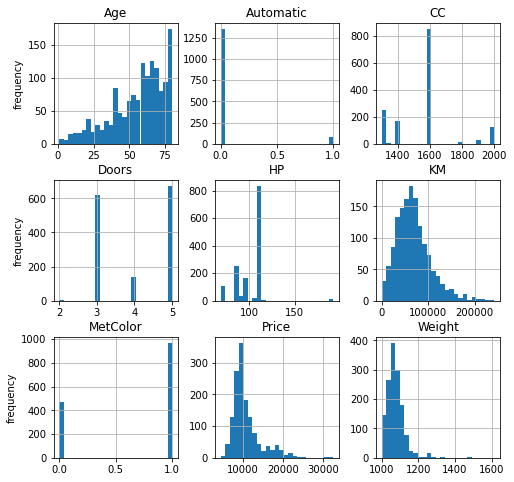

In [7]:
axList = data_tr[data_tr.columns[data_tr.dtypes==np.int64]].hist(bins=25 ,figsize = (8,8))
for ax in axList.flatten():
    if ax.is_first_col():
        ax.set_ylabel('frequency')
        


**We get to know from the above plot that variable 'Automatic' , 'CC' , 'Doors' ,'HP' ,'MetColor' are categorical and are ordinal variable except 'MetColor' and 'Automatic'**

**Here our target variable of interest  is Price of car lets first check whether it is normally distributed or not**

[Text(0.5, 0, 'Price of Toyota Car'),
 Text(0.5, 1.0, ' Frequency distribution of price of toyota car')]

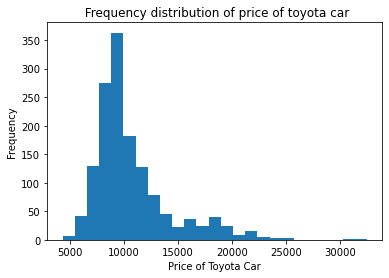

In [8]:
ax = data_tr['Price'].plot.hist(bins = 25)
ax.set(xlabel = 'Price of Toyota Car',
      title = " Frequency distribution of price of toyota car")

**from the above plot it is clear that price of car is positively skewed. It is not normal distributed**

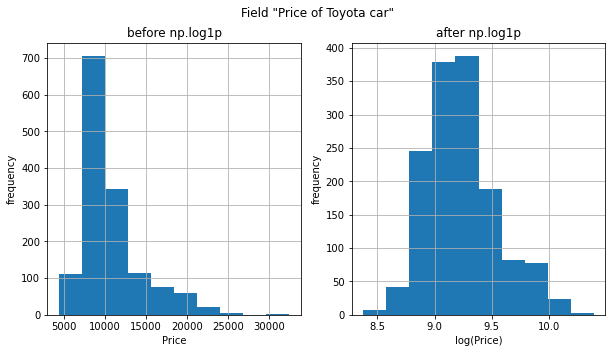

In [9]:
# Let's look at what happens to Price, when we apply np.log1p visually.

# Create two "subplots" and a "figure" using matplotlib
fig, (ax_before, ax_after) = plt.subplots(1, 2, figsize=(10, 5))

# Create a histogram on the "ax_before" subplot
data_tr['Price'].hist(ax=ax_before)

# Apply a log transformation (numpy syntax) to this column
data_tr['Price'].apply(np.log1p).hist(ax=ax_after)

# Formatting of titles etc. for each subplot
ax_before.set(title='before np.log1p', ylabel='frequency', xlabel='Price')
ax_after.set(title='after np.log1p', ylabel='frequency', xlabel='log(Price)')
fig.suptitle('Field "{}"'.format('Price of Toyota car'));

In [10]:
from scipy.stats import normaltest
statistics , p =normaltest(np.log1p(data_tr['Price']))
if (p > 0.05):
    print('Price of car is normally distributed after log transformation')
else :
    print('Price of car is not normally distributed after log transformation')
print('pvalue is :-',p)

Price of car is not normally distributed after log transformation
pvalue is :- 1.0018988063780995e-26


**Thus also after the log transformation Price is not normal distributed lets try with boxcox transformation**

In [11]:
from scipy.stats import boxcox
z,lamb = boxcox(data_tr['Price'])
statistics , p =normaltest(z)
if (p > 0.05):
    print('Price of car is normally distributed after boxcox transformation')
else :
    print('Price of car is not normally distributed after boxcox transformation')
print('pvalue is :-' ,p)

Price of car is not normally distributed after boxcox transformation
pvalue is :- 0.018972015148861304


**From the above two transformation p value result we can say that boxcox transformation is working very well then the log transformation to transform the price of car in normal distributed variable . So , we can consider box cox transformation for our further model building**

In [12]:
num_col = ['KM','Price','CC' , 'Weight' ,'Age' ,'HP']

[Text(0.5, 1.0, 'Boxplot after MinMax Scaling quantitative variable')]

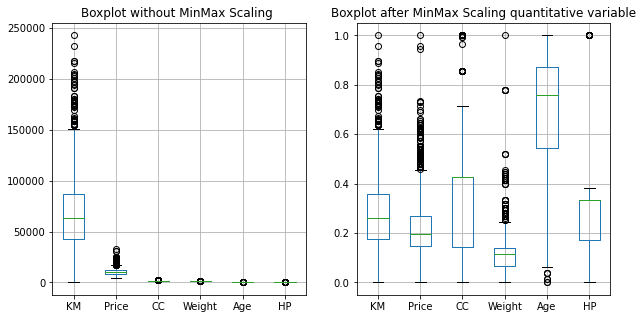

In [13]:
from sklearn.preprocessing import MinMaxScaler
MMS = MinMaxScaler()
MMS.fit(data_tr.loc[:,num_col])
tt = MMS.transform(data_tr.loc[:,num_col])
tt = pd.DataFrame(tt)
tt.columns = ['KM','Price','CC' , 'Weight' ,'Age' ,'HP']


# Checking for outliers in our data
fig ,(ax_before ,ax_after) = plt.subplots(1,2 ,figsize = (10,5))
tt.boxplot(ax = ax_after)
data_tr.loc[:,num_col].boxplot(ax = ax_before)
ax_before.set(title = 'Boxplot without MinMax Scaling ')
ax_after.set(title = 'Boxplot after MinMax Scaling quantitative variable')

In [14]:
import seaborn as sns
(data_tr.drop(columns=num_col))

MetColor  Automatic  Doors  FuelType_Diesel  FuelType_Petrol
0            1          0      3                1                0
1            1          0      3                1                0
2            1          0      3                1                0
3            0          0      3                1                0
4            0          0      3                1                0
...        ...        ...    ...              ...              ...
1431         1          0      3                0                1
1432         0          0      3                0                1
1433         0          0      3                0                1
1434         1          0      3                0                1
1435         0          0      5                0                1

[1436 rows x 5 columns]

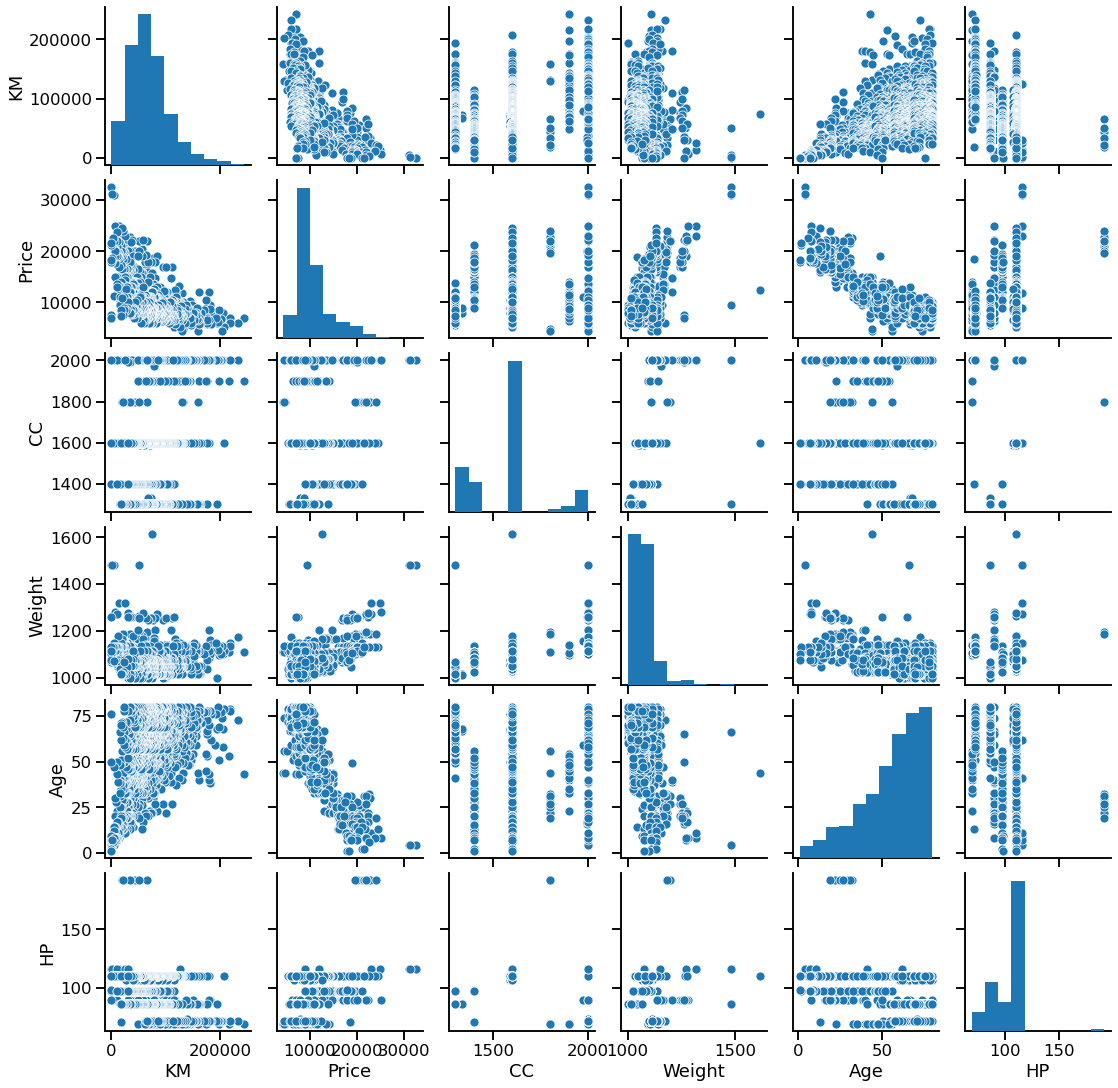

In [15]:
### BEGIN SOLUTION
sns.set_context('talk')
sns.pairplot(data_tr[num_col] )

In [16]:
data_tr.head()

Price  Age     KM  HP  MetColor  Automatic    CC  Doors  Weight  \
0  13500   23  46986  90         1          0  2000      3    1165   
1  13750   23  72937  90         1          0  2000      3    1165   
2  13950   24  41711  90         1          0  2000      3    1165   
3  14950   26  48000  90         0          0  2000      3    1165   
4  13750   30  38500  90         0          0  2000      3    1170   

   FuelType_Diesel  FuelType_Petrol  
0                1                0  
1                1                0  
2                1                0  
3                1                0  
4                1                0

4. Summary of training at least three linear regression models which should be variations that cover using a simple linear regression as a baseline, adding polynomial effects, and using a regularization regression. Preferably, all use the same training and test splits, or the same cross-validation method.

(a.)  Simple Linear Regression without polynomial features

In [17]:
X = data_tr.drop('Price', axis=1)
y = data_tr.Price

- Creating K Fold training and testing set

In [19]:
from sklearn.model_selection import KFold
kf  = KFold(n_splits = 5 , random_state = 42 ,shuffle = True)

for train_index, test_index in kf.split(X):
    print("Train index:", train_index[:10], len(train_index))
    print("Test index:",test_index[:10], len(test_index))
    print('')

Train index: [0 1 2 3 4 5 6 7 8 9] 1148
Test index: [15 23 29 30 32 43 44 49 51 56] 288

Train index: [ 0  1  2  4  6  7  8  9 11 13] 1149
Test index: [ 3  5 10 12 31 39 48 54 59 83] 287

Train index: [ 1  3  4  5  8 10 11 12 13 14] 1149
Test index: [ 0  2  6  7  9 25 27 33 45 47] 287

Train index: [ 0  1  2  3  5  6  7  8  9 10] 1149
Test index: [ 4 11 16 17 18 19 22 24 28 35] 287

Train index: [ 0  2  3  4  5  6  7  9 10 11] 1149
Test index: [ 1  8 13 14 20 21 26 34 37 40] 287



- Checking training error on different test set 

In [20]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

scores_lr = []
lr = LinearRegression()

for train_index, test_index in kf.split(X):
    X_train, X_test, y_train, y_test = (X.iloc[train_index, :], 
                                        X.iloc[test_index, :], 
                                        y[train_index], 
                                        y[test_index])
    
    lr.fit(X_train, y_train)
        
    y_pred = lr.predict(X_test)

    score = r2_score(y_test.values, y_pred)
    
    scores_lr.append(score)
    
scores_lr

[0.8463009058053605,
 0.8516617085360746,
 0.8713216872861502,
 0.8734847611130779,
 0.8583923728040344]

(b.) Simple Linear Regression with all 2nd order polynomial features

- Adding Polynomial  features 

In [21]:
from sklearn.preprocessing import  PolynomialFeatures
pf = PolynomialFeatures(degree = 2 ,include_bias = False)
X_pf = pf.fit_transform(X)
X_pf = pd.DataFrame(X_pf)
X_pf.head()

0        1     2    3    4       5    6       7    8    9   ...   55  \
0  23.0  46986.0  90.0  1.0  0.0  2000.0  3.0  1165.0  1.0  0.0  ...  9.0   
1  23.0  72937.0  90.0  1.0  0.0  2000.0  3.0  1165.0  1.0  0.0  ...  9.0   
2  24.0  41711.0  90.0  1.0  0.0  2000.0  3.0  1165.0  1.0  0.0  ...  9.0   
3  26.0  48000.0  90.0  0.0  0.0  2000.0  3.0  1165.0  1.0  0.0  ...  9.0   
4  30.0  38500.0  90.0  0.0  0.0  2000.0  3.0  1170.0  1.0  0.0  ...  9.0   

       56   57   58         59      60   61   62   63   64  
0  3495.0  3.0  0.0  1357225.0  1165.0  0.0  1.0  0.0  0.0  
1  3495.0  3.0  0.0  1357225.0  1165.0  0.0  1.0  0.0  0.0  
2  3495.0  3.0  0.0  1357225.0  1165.0  0.0  1.0  0.0  0.0  
3  3495.0  3.0  0.0  1357225.0  1165.0  0.0  1.0  0.0  0.0  
4  3510.0  3.0  0.0  1368900.0  1170.0  0.0  1.0  0.0  0.0  

[5 rows x 65 columns]

- Checking Training error on different test set 

In [22]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

scores_lr_pf = []
lr = LinearRegression()

for train_index, test_index in kf.split(X):
    X_train, X_test, y_train, y_test = (X_pf.iloc[train_index, :], 
                                        X_pf.iloc[test_index, :], 
                                        y[train_index], 
                                        y[test_index])
    
    lr.fit(X_train, y_train)
        
    y_pred = lr.predict(X_test)

    score = r2_score(y_test.values, y_pred)
    
    scores_lr_pf.append(score)
    
scores_lr_pf

[0.744794689714854,
 0.8923058597980359,
 0.8982241850460506,
 0.8940510680742745,
 0.7507977888929567]

(c) Lasso Regression with polynomial feature upto 2nd order

- Now we have to perform scaling of features as we are doing regularization using L1 penalty . We have not done scaling while performing vanila regression before as feature scaling does not matter in performance of model

In [27]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_predict

ls = Lasso(alpha = 1.0 , max_iter = 100000)
s = StandardScaler()
estimator = Pipeline([("scaler", s),
                      ("regression", ls)])
predictions = cross_val_predict(estimator, X_pf , y, cv=kf)
scores_ls = r2_score(y, predictions)
scores_ls


0.8953217277670256

- Above I have arbitarily chosen the value of hyperparameter as 1 . One can hypertune this hyperparameter with best possible choice . I have taken 1.0 as there are lot feature in the data and I want to have descent penalty ,so, that the coefficient of irrelevant variable is exactly zero 

5. A paragraph explaining which of your regressions you recommend as a final model that best fits your needs in terms of accuracy and explainability.


In [32]:
pd.DataFrame({'linear_regression': scores_lr , 'linear_regression_polynomial_feat': scores_lr_pf ,
              'lasso_regression': scores_ls})

linear_regression  linear_regression_polynomial_feat  lasso_regression
0           0.846301                           0.744795          0.895322
1           0.851662                           0.892306          0.895322
2           0.871322                           0.898224          0.895322
3           0.873485                           0.894051          0.895322
4           0.858392                           0.750798          0.895322

- We can see from the above table that lasso regression is outperforming all other model in terms of explaining the variance of the variable 'Price of the Toyota Car' . 89.5% of the  variability of the response is exlpained by the lasso regression model . Also , we have some  advantage of model interpreatability 

6. Summary Key Findings and Insights, which walks your reader through the main drivers of your model and insights from your data derived from your linear regression model.

Key Findings are as follows :- 
- Price of car decreases as age of car decreases  and vice versa
- Price of car is high if the car is automatic car 
- Approx 90% of the variance in Price of the car is explained by the regression model

7. Suggestions for next steps in analyzing this data, which may include suggesting revisiting this model adding specific data features to achieve a better explanation or a better prediction.

- We can  hypertune the parameter of the lasso regression in our next step to get the best possible result 
- We can implment GridSearch or any other merhod to search the best hyper paramater 
- We can try to get the coefficient of the features and we can analyse them further for model interpreatation part 